In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/bnreel/BNREEL_text.csv")
df

,file_id,class,text,source,category
0,1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie,Facebook,Safe
1,1006146964533997,Safe,[NULL],Facebook,Safe
2,1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,Facebook,Unsafe
3,1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,Facebook,Safe
4,1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,Facebook,Safe
...,...,...,...,...,...
1916,3356285208118215619_62841927222,Safe,The amount of comfort this scene gives >>,Instagram,Safe
1917,3363424170779680862_62841927222_2,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1918,3363424170779680862_62841927222_3,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1919,3363424170779680862_62841927222_,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe


In [3]:
df['category'], uniques = pd.factorize(df['category'])
uniques

Index(['Safe', 'Unsafe'], dtype='object')

In [4]:
dir1 = "/kaggle/input/bnreel/Audio_V1/Audio_V1"
dir2 = "/kaggle/input/bnreel/Audio_V2/Audio_V2"
dir3 = "/kaggle/input/bnreel/UNBER_IG/UNBER_IG/Audio_IG"

In [5]:
pip install noisereduce --quiet

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [7]:
def process_audio_file(file_path, target_length=15, sample_rate=22050, n_mfcc=13, n_chroma=12, 
                       n_spectral_contrast=6, target_length_features=20):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Trim or pad audio to target length
    target_samples = target_length * sr
    if len(audio) > target_samples:
        audio = audio[:target_samples]  # Trim
    else:
        padding = target_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')  # Pad with silence

    # Normalize audio (zero mean, unit variance)
    mean = np.mean(audio)
    std = np.std(audio)
    safe_std = max(std, 1e-8)  # Avoid division by zero
    audio = (audio - mean) / safe_std

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    if not np.isfinite(reduced_noise_audio).all():
        print("Warning: Noise reduction produced NaN/Inf values, reverting to original audio.")
        reduced_noise_audio = audio  # Use original if noise reduction fails
    
    reduced_noise_audio = np.nan_to_num(reduced_noise_audio)

    # Feature Extraction
    def truncate_or_pad(feature, target_length_features):
        """Ensures features have a fixed length by truncating or padding."""
        if feature.shape[1] > target_length_features:
            return feature[:, :target_length_features]
        else:
            return np.pad(feature, ((0, 0), (0, target_length_features - feature.shape[1])), mode='constant')

    # Extract MFCCs (13 coefficients)
    mfcc = librosa.feature.mfcc(y=reduced_noise_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = truncate_or_pad(mfcc, target_length_features)

    # Extract Chroma Features (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=reduced_noise_audio, sr=sr, n_chroma=n_chroma)
    chroma = truncate_or_pad(chroma, target_length_features)

    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=reduced_noise_audio, sr=sr)
    spectral_centroid = truncate_or_pad(spectral_centroid, target_length_features)

    # Extract Spectral Contrast (6 bands)
    spectral_contrast = librosa.feature.spectral_contrast(y=reduced_noise_audio, sr=sr, n_bands=n_spectral_contrast)
    spectral_contrast = truncate_or_pad(spectral_contrast, target_length_features)

    # Extract Spectrogram (Magnitude Spectrogram)
    spectrogram = np.abs(librosa.stft(reduced_noise_audio))
    spectrogram = truncate_or_pad(spectrogram, target_length_features)

    # Flatten all features into a single vector
    feature_vector = np.concatenate([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_centroid.flatten(),
        spectral_contrast.flatten(),
        spectrogram.flatten()
    ])

    return feature_vector

In [8]:
X = []
y = []

In [9]:
for _, row in df.iterrows():
    reel_id = row["file_id"]
    label = row["category"]  

    for dir in list([dir1, dir2, dir3]):
        audio_file = os.path.join(dir, f"{reel_id}.wav")
        if os.path.exists(audio_file): 
            processed_audio = process_audio_file(audio_file)      
            X.append(processed_audio)
            y.append(label)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [10]:
X = np.array(X, dtype=np.float32)

In [11]:
X.shape

(1905, 21160)

In [12]:
y = np.array(y)
y.shape

(1905,)

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
import numpy as np

combined = list(zip(X, y))

np.random.shuffle(combined)

X, y = zip(*combined)

X = np.array(X)
y = np.array(y)

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# VGGish expects input shape (96, 64) — log-mel spectrogram
vggish = hub.KerasLayer("https://tfhub.dev/google/vggish/1",
                        input_shape=(21160,),
                        trainable=True)  # Enable training if you want fine-tuning

In [36]:
# Define a custom VGGish wrapper layer
class VGGishWrapper(tf.keras.layers.Layer):
    def __init__(self):
        super(VGGishWrapper, self).__init__()
        self.vggish = hub.load("https://tfhub.dev/google/vggish/1")

    def call(self, inputs):
        # Apply VGGish module on each sample individually
        return tf.map_fn(lambda x: self.vggish(x), inputs, dtype=tf.float32)

In [38]:
# Input shape must be 1D raw audio waveform per sample (e.g. 15360 samples)
input_audio = tf.keras.Input(shape=(21160,), dtype=tf.float32)

# Apply the VGGish feature extractor
x = VGGishWrapper()(input_audio)
x = tf.keras.layers.Reshape((128,))(x)

# Classification head
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

output = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Change to softmax for multiclass

# Build the model
model = tf.keras.Model(inputs=input_audio, outputs=output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 21160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vg_gish_wrapper_3 (VGGishWrapper)    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,833 (97.00 KB)

 Trainable params: 24,833 (97.00 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [44]:
history = model.fit(
    X_train, y_train,  # training data
    epochs=50,  # number of epochs
    batch_size=64,  # batch size
    validation_data=(X_val, y_val),  # validation data
    callbacks=[early_stopping, lr_scheduler]  # early stopping
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5147 - loss: 0.6910 - val_accuracy: 0.5757 - val_loss: 0.6895 - learning_rate: 5.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5343 - loss: 0.6953 - val_accuracy: 0.5757 - val_loss: 0.6891 - learning_rate: 5.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5476 - loss: 0.6903 - val_accuracy: 0.5724 - val_loss: 0.6891 - learning_rate: 5.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5273 - loss: 0.6947 - val_accuracy: 0.5789 - val_loss: 0.6889 - learning_rate: 5.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5383 - loss: 0.6831 - val_accuracy: 0.5592 - val_loss: 0.6887 - learning_rate: 5.0000e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5465 - loss: 0.6908 - val_accuracy: 0.5625 - val_loss: 0.6888 - learning_rate: 5.0000e-05
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5702 - loss:

In [45]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred >= 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step


In [46]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.15      0.23        34
           1       0.57      0.91      0.70        43

    accuracy                           0.57        77
   macro avg       0.56      0.53      0.47        77
weighted avg       0.57      0.57      0.50        77



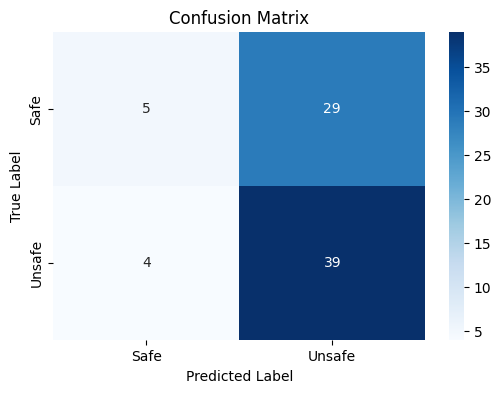

In [47]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Safe","Unsafe"], yticklabels=["Safe","Unsafe"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()